# **1 Model Confidense Set**

To apply the model confidence set to evaluate what models are best we need to compute a loss for every observation. For recurrent og deep architectures this notion is straightforward. However, for sequence-to-sequence modelling (like implemented for recurrent neural networks) we need think carefully about evaluating the loss at a given time.

We will try to implement the model confidence set by taking the average loss for each sercurity on each day.

If we have sliding window of length $T$ then the first $T-1$ observations predictions have less than $T$ predictions. The first observation will have $1$ prediction, the second $2$ predictions, third $3$ predictions, etc. until the $T-1$'th prediction which has $T-1$ predictions.

Let $L(y_{i,t})$ denote the loss of observation $t$ for stock $i$. Let $L(y^{(s)}_{i,t})$ denote the loss of observation $t$ for stock $i$ from sample $s$, where $s \in \mathbb{S}$. For the recurrent neural network we thus define the point loss as

$$
\hat{L}(y_{i,t}) = \frac{1}{|\mathbb{S}|} \sum_{s \in \mathbb{S}} L(\hat{y}^{(s)}_{i,t})
$$
, where $|\mathbb{S}|$ denotes the count of total samples for that observation.

An alternative approach is to just use the final stock prediction, which is based on all previous prediction (i.e use the final element of each vector). However, we have not optimized for this.

# **2 Imports**

In [1]:
# Mount drive
from google.colab import drive; drive.mount('/content/drive')

# CD to current directory
%cd /content/drive/MyDrive/Colab Notebooks/Bachelor Thesis/Notebooks/Model Comparison

Mounted at /content/drive
/content/drive/MyDrive/Colab Notebooks/Bachelor Thesis/Notebooks/Model Comparison


In [2]:
! sudo apt-get update
! sudo apt-get install texlive-latex-recommended
! sudo apt-get install dvipng texlive-latex-extra texlive-fonts-recommended
! wget http://mirrors.ctan.org/macros/latex/contrib/type1cm.zip
! unzip type1cm.zip -d /tmp/type1cm
! cd /tmp/type1cm/type1cm/ && sudo latex type1cm.ins
! sudo mkdir /usr/share/texmf/tex/latex/type1cm
! sudo cp /tmp/type1cm/type1cm/type1cm.sty /usr/share/texmf/tex/latex/type1cm
! sudo texhash
!apt install cm-super
import matplotlib as mpl

mpl.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "text.latex.preamble": r"""
        \usepackage{type1cm}
        \usepackage{amsmath}
    """
})

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Hit:3 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:4 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:5 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [1,683 kB]
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Get:10 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:11 https://r2u.stat.illinois.edu/ubuntu jammy/main all Packages [8,958 kB]
Get:12 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease [24.6 kB]
Get:13 http://security.ubuntu.com/ubuntu

## **2.1 Packages**

In [3]:
!pip install -q model-confidence-set

import gc
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from collections import defaultdict
from model_confidence_set import ModelConfidenceSet

## **2.2 Data**

We note that the models need different datastructures. FFNN and D-FFNN use $D \in \mathbb{R}^{(F \cdot T) \times F}$ and RNN and LSTM use $D \in \mathbb{R}^{N \times T \times F}$

### **2.2.1 Import**

In [4]:
# Relative location of data
DATA_RLOC = '../Data/handoffs/data_stock_returns_final.parquet'

# Load data and sort by eom
securities_data = pd.read_parquet(DATA_RLOC)
securities_data = securities_data.sort_values(by=['id', 'eom'])

# List of features and the label
features = [
    feat for feat in securities_data.columns
    if feat not in ['eom', 'id', 'ret_exc_lead1m']
]

label = 'ret_exc_lead1m'

### **2.2.2 Processing Functions**

In [5]:
def build_tensors(securities_data, features, label, window_len):
  """
  Takes dataframe as input, the features, and labels and returns a feature
  tensor of dimension (N, T, F) and a label tensor of dimension (N, T, 1)
  """

  # Ensure data is sorted correctly
  securities_data = securities_data.sort_values(by=['id', 'eom'])

  X_all, y_all = [], []

  for _, group in securities_data.groupby('id', sort=False):
      feats  = group[features].values
      labels = group[label].values.reshape(-1, 1)
      D = len(group)

      for start in range(D - window_len + 1):
          end = start + window_len
          X_all.append(feats[start:end])    # (T, F)
          y_all.append(labels[start:end])   # (T, 1)

  X = np.stack(X_all)  # (N, T, F)
  y = np.stack(y_all)  # (N, T, 1)

  del X_all, y_all, group, label, features
  gc.collect()
  return X, y

### **2.2.3 Train/Validation/Test Split**

In [6]:
# Time-based split
months = sorted(securities_data['eom'].unique())
n      = len(months)
splits = [int(n * 0.7), int(n * 0.85)]

month_bins = [
    months[:splits[0]],             # Train
    months[splits[0]:splits[1]],    # Validation
    months[splits[1]:],             # Test
]


# securities_data[0]: train data
# securities_data[1]: validation data
# securities_data[2]: test data
securities_data = [
    securities_data[securities_data['eom'].isin(m)] for m in month_bins
]

We create train/validation/test splits for each model.

In [7]:
# Train, validation and test data for FFNN and D-FFNN
ff_X_train, ff_y_train = securities_data[0][features], securities_data[0][label]
ff_X_val,   ff_y_val   = securities_data[1][features], securities_data[1][label]
ff_X_test,  ff_y_test  = securities_data[2][features], securities_data[2][label]

# Train, validation and test data for RNN
rnn_X_train, rnn_y_train = build_tensors(securities_data[0], features, label, 36)
rnn_X_val,   rnn_y_val   = build_tensors(securities_data[1], features, label, 36)
rnn_X_test,  rnn_y_test  = build_tensors(securities_data[2], features, label, 36)

# Train, validation and test data for LSTM
lstm_X_train, lstm_y_train = build_tensors(securities_data[0], features, label, 6)
lstm_X_val,   lstm_y_val   = build_tensors(securities_data[1], features, label, 6)
lstm_X_test,  lstm_y_test  = build_tensors(securities_data[2], features, label, 6)

In [8]:
del securities_data

## **2.3 models**

In [9]:
# Relative location of Keras models
FFNN_RLOC  = '../Feed Forward Neural Nets/models studies/final_model_fnn.keras'
DFFNN_RLOC = '../Deep Neural Networks/models studies/final_model_dffn.keras'
RNN_RLOC   = '../Recurrent Neural Nets/models studies/final_model_rnn.keras'
LSTM_RLOC  = '../LSTM/models studies/final_model_lstm.keras'

# Load models
ffnn  = tf.keras.models.load_model(FFNN_RLOC)
dffnn = tf.keras.models.load_model(DFFNN_RLOC)
rnn   = tf.keras.models.load_model(RNN_RLOC)
lstm  = tf.keras.models.load_model(LSTM_RLOC)

# **3 Evaluation Losses on Test Data**

We define the loss for each observation as the squared error.

In total we have 938 securities and 36 dates in the test sample.

## **3.1 Feed Forward Neural Network Losses**

For feed forward network types we make one prediction per observation. So no need to calcualte special losses. This goes for both feed forward and deep feed forward.

The first return is stock 1, eom 1, the second is stock 1 eom 2, etc.

In [10]:
# Predict on test data
ffnn_predict_test = ffnn.predict(ff_X_test, verbose=0)

# Calculate losses for Model Confidence Set (mcs)
ffnn_mcs_losses = np.square(ffnn_predict_test.flatten() - ff_y_test.values.flatten())

## **3.2 Deep Feed Forward Neural Network Losses**

Same as with feed forward.

In [11]:
# Predict on test data
dffnn_predict_test = dffnn.predict(ff_X_test, verbose=0)

# Calculate losses for Model Confidence Set (mcs)
dffnn_mcs_losses = np.square(dffnn_predict_test.flatten() - ff_y_test.values.flatten())

## **3.3 Recurrent Neural Network Losses**

Since the sequence length is exactly the amount of observations we do not need to worry about making several predictions per stock.

In [12]:
# Predict on test data
rnn_predict_test = rnn.predict(rnn_X_test, verbose=0)

# Calcualte losses used for Model Confidence Set (mcs)
rnn_mcs_losses = np.square(rnn_y_test.flatten() - rnn_predict_test.flatten())

## **3.4 Long Short Term Memory Losses**

Here we need to think carefully about how the loss for each day is calculated.

In [13]:
lstm_predict_test = lstm.predict(lstm_X_test, verbose=0)

First we group the predictions by date and security.

In [14]:
n_stocks = 938
n_dates = 36
window_len = 6
samples_per_stock = n_dates - window_len + 1  # 31
total_samples = n_stocks * samples_per_stock  # 29078

# Flatten predictions and errors
pred_vals = lstm_predict_test.squeeze(-1)       # shape (29078, 6)
label_vals = lstm_y_test.squeeze(-1)            # shape (29078, 6)
squared_errors = (pred_vals - label_vals) ** 2  # shape (29078, 6)

# Identify stock and date for each prediction to
stock_ids = np.repeat(np.arange(n_stocks), samples_per_stock)    # shape (29078,)
window_starts = np.tile(np.arange(samples_per_stock), n_stocks)  # shape (29078,)
date_indices = window_starts[:, None] + np.arange(window_len)    # shape (29078, 6)

# Flatten to per-prediction entries
flat_stock_ids = np.repeat(stock_ids, window_len)  # shape (29078 * 6,)
flat_date_indices = date_indices.flatten()         # shape (29078 * 6,)
flat_squared_errors = squared_errors.flatten()     # shape (29078 * 6,)

# Accumulate sum of squared errors and counts
sum_errors = np.zeros((n_stocks, n_dates))
count_errors = np.zeros((n_stocks, n_dates))
np.add.at(sum_errors, (flat_stock_ids, flat_date_indices), flat_squared_errors)
np.add.at(count_errors, (flat_stock_ids, flat_date_indices), 1)

# Compute mean squared error per stock/date
with np.errstate(divide='ignore', invalid='ignore'):
    avg_mse = np.divide(sum_errors, count_errors, where=count_errors != 0)

# Final array of errors
lstm_mcs_losses = avg_mse.flatten()

# **4 Evaluation Losses on Validation Data**

We define the loss for each observation as the squared error.

In total we have 938 securities and 36 dates in the test sample.

## **4.1 Feed Forward Neural Network Losses**

For feed forward network types we make one prediction per observation. So no need to calcualte special losses. This goes for both feed forward and deep feed forward.

The first return is stock 1, eom 1, the second is stock 1 eom 2, etc.

In [15]:
# Predict on test data
ffnn_predict_val = ffnn.predict(ff_X_val, verbose=0)

# Calculate losses for Model Confidence Set (mcs)
ffnn_mcs_val_losses = np.square(ffnn_predict_val.flatten() - ff_y_val.values.flatten())

## **4.2 Deep Feed Forward Neural Network Losses**

Same as with feed forward.

In [16]:
# Predict on test data
dffnn_predict_val = dffnn.predict(ff_X_val, verbose=0)

# Calculate losses for Model Confidence Set (mcs)
dffnn_mcs_val_losses = np.square(dffnn_predict_val.flatten() - ff_y_val.values.flatten())

## **4.3 Recurrent Neural Network Losses**

Since the sequence length is exactly the amount of observations we do not need to worry about making several predictions per stock.

In [17]:
# Predict on test data
rnn_predict_val = rnn.predict(rnn_X_val, verbose=0)

# Calcualte losses used for Model Confidence Set (mcs)
rnn_mcs_val_losses = np.square(rnn_y_val.flatten() - rnn_predict_val.flatten())

## **4.4 Long Short Term Memory Losses**

Here we need to think carefully about how the loss for each day is calculated.

In [18]:
lstm_predict_val = lstm.predict(lstm_X_val, verbose=0)

In [19]:
n_stocks = 938
n_dates = 36
window_len = 6
samples_per_stock = n_dates - window_len + 1  # 31
total_samples = n_stocks * samples_per_stock  # 29078

# Flatten predictions and errors
pred_vals = lstm_predict_val.squeeze(-1)       # shape (29078, 6)
label_vals = lstm_y_val.squeeze(-1)            # shape (29078, 6)
squared_errors = (pred_vals - label_vals) ** 2  # shape (29078, 6)

# Identify stock and date for each prediction to
stock_ids = np.repeat(np.arange(n_stocks), samples_per_stock)    # shape (29078,)
window_starts = np.tile(np.arange(samples_per_stock), n_stocks)  # shape (29078,)
date_indices = window_starts[:, None] + np.arange(window_len)    # shape (29078, 6)

# Flatten to per-prediction entries
flat_stock_ids = np.repeat(stock_ids, window_len)  # shape (29078 * 6,)
flat_date_indices = date_indices.flatten()         # shape (29078 * 6,)
flat_squared_errors = squared_errors.flatten()     # shape (29078 * 6,)

# Accumulate sum of squared errors and counts
sum_errors = np.zeros((n_stocks, n_dates))
count_errors = np.zeros((n_stocks, n_dates))
np.add.at(sum_errors, (flat_stock_ids, flat_date_indices), flat_squared_errors)
np.add.at(count_errors, (flat_stock_ids, flat_date_indices), 1)

# Compute mean squared error per stock/date
with np.errstate(divide='ignore', invalid='ignore'):
    avg_mse = np.divide(sum_errors, count_errors, where=count_errors != 0)

# Final array of errors
lstm_mcs_val_losses = avg_mse.flatten()

# **5 Model Confidence Set**

## **5.1 Test dataset**

In [21]:
# Losses dataframe
mcs_losses = pd.DataFrame(np.c_[ffnn_mcs_losses, dffnn_mcs_losses, rnn_mcs_losses, lstm_mcs_losses], columns=['ffnn', 'dffnn', 'rnn', 'lstm'])

First we test on the test data (most important).

In [ ]:
mcs = ModelConfidenceSet(mcs_losses, n_boot=10_000, alpha=0.05, show_progress=True)
mcs.compute()
print(mcs.results())

Computing MCS: 100%|██████████| 3/3 [00:00<00:00, 485.26model/s]

        pvalues    status
models                   
rnn      0.0000  excluded
lstm     0.0000  excluded
ffnn     0.0005  excluded
dffnn    1.0000  included


In [ ]:
mcs_losses = mcs_losses.drop(columns='dffnn')
mcs = ModelConfidenceSet(mcs_losses, n_boot=10_000, alpha=0.05, show_progress=True)
mcs.compute()
print(mcs.results())

Computing MCS: 100%|██████████| 2/2 [00:00<00:00, 1036.40model/s]

        pvalues    status
models                   
rnn      0.0007  excluded
ffnn     0.8169  included
lstm     1.0000  included


## **5.2 Validation Dataset**

In [ ]:
# Validation losses dataframe
mcs_losses_val = pd.DataFrame(np.c_[ffnn_mcs_val_losses, dffnn_mcs_val_losses, rnn_mcs_val_losses, lstm_mcs_val_losses], columns=['ffnn', 'dffnn', 'rnn', 'lstm'])

Second we look for fun at the validation losses.

In [ ]:
mcs_val = ModelConfidenceSet(mcs_losses_val, n_boot=10_000, alpha=0.05, show_progress=True)
mcs_val.compute()
print(mcs_val.results())

Computing MCS: 100%|██████████| 3/3 [00:00<00:00, 894.75model/s]

        pvalues    status
models                   
lstm     0.0000  excluded
dffnn    0.0051  excluded
rnn      0.0978  included
ffnn     1.0000  included


In [ ]:
mcs_losses_val = mcs_losses_val.drop(columns=['ffnn', 'rnn'])
mcs = ModelConfidenceSet(mcs_losses_val, n_boot=10_000, alpha=0.05, show_progress=True)
mcs.compute()
print(mcs.results())

Computing MCS: 100%|██████████| 1/1 [00:00<00:00, 723.53model/s]

        pvalues    status
models                   
lstm     0.1595  included
dffnn    1.0000  included


Removing `lstm` yields.

In [ ]:
mcs_val = ModelConfidenceSet(mcs_losses_val.drop(columns=['lstm']), n_boot=10_000, alpha=0.05, show_progress=True)
mcs_val.compute()
print(mcs_val.results())

Computing MCS: 100%|██████████| 2/2 [00:00<00:00, 835.94model/s]

        pvalues    status
models                   
dffnn    0.0051  excluded
rnn      0.1009  included
ffnn     1.0000  included


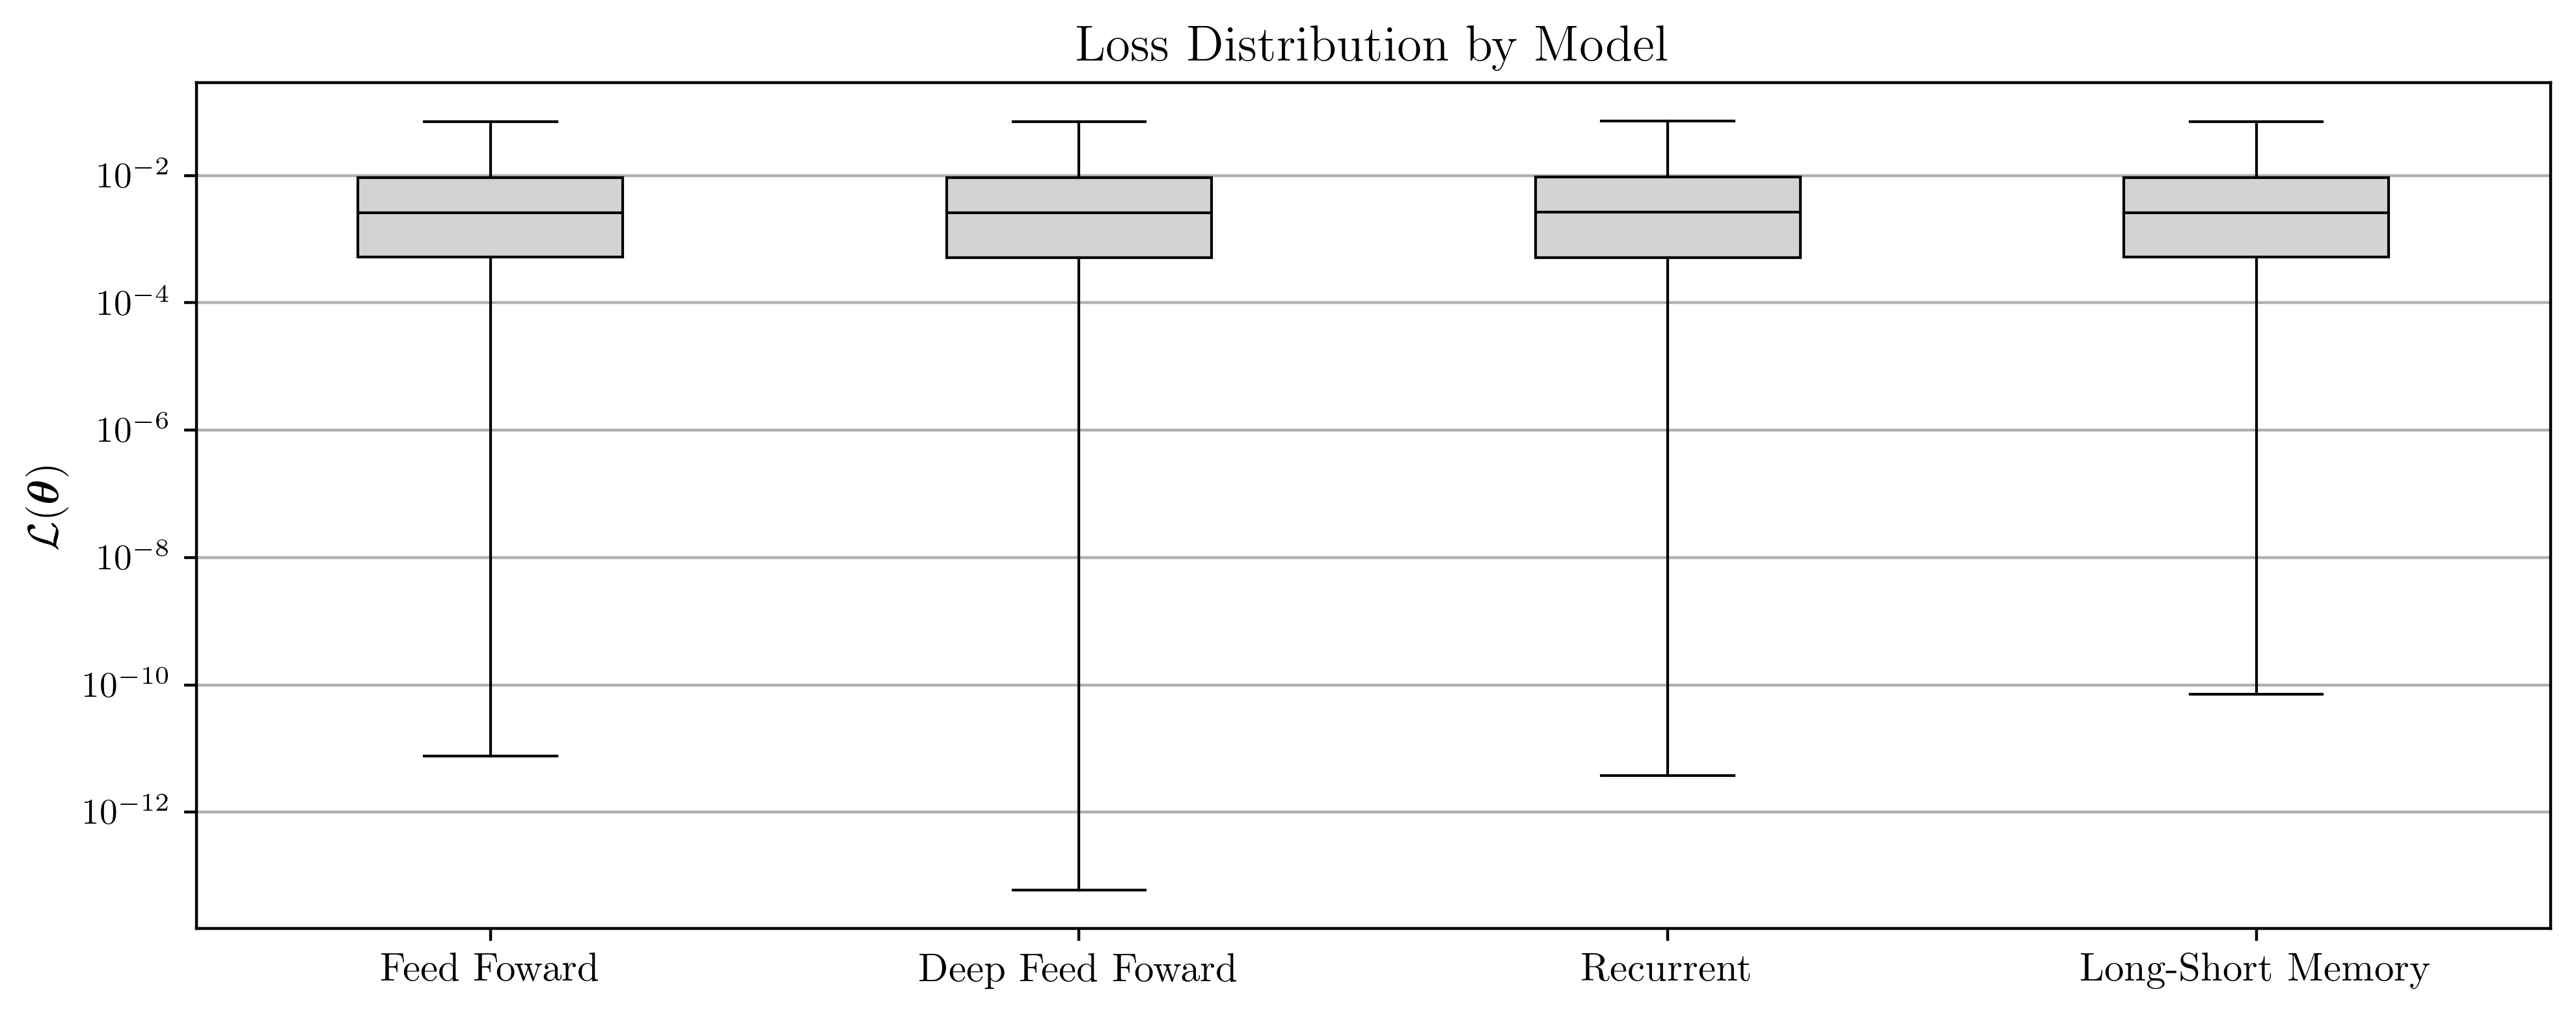

In [28]:
# Set up the figure
plt.figure(figsize=(10, 4), dpi=400)

# Create boxplot
box = mcs_losses.boxplot(
    column=['ffnn', 'dffnn', 'rnn', 'lstm'],
    whis=7,
    showfliers=False,
    patch_artist=True,
    boxprops=dict(facecolor='lightgray', color='black', linewidth=0.75),
    medianprops=dict(color='black', linewidth=0.75),
    whiskerprops=dict(color='black', linewidth=0.75),
    capprops=dict(color='black', linewidth=0.75)
)


# Minimalist styling
plt.title('Loss Distribution by Model', fontsize=14)
plt.ylabel(r'$\mathcal{L}(\boldsymbol{\theta})$', fontsize=12)
plt.xticks(ticks=range(1, 5), labels=['Feed Foward', 'Deep Feed Foward', 'Recurrent', 'Long-Short Memory'], fontsize=11)
plt.yscale("log")
plt.grid(axis='x')

plt.tight_layout()
plt.savefig("losses_by_model.pdf", bbox_inches='tight', dpi=400)
plt.show()